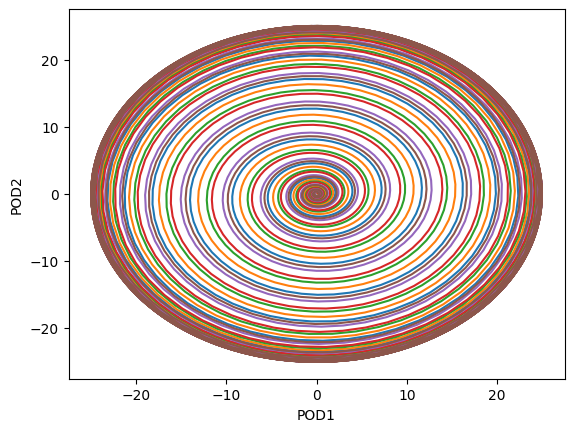

In [2]:
from scipy.io import loadmat
from ssmlearnpy import SSMLearn
from ssmlearnpy.reduced_dynamics.advector import advect
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

mat = loadmat('data.mat')
n_traj = len(mat['PODTraj'])
idx_train = [0, 2, 4, 5, 7, 8]
idx_test = [1, 3, 6]
n_traj_train, n_traj_test = len(idx_train), len(idx_test)

t_train = [mat['PODTraj'][i][0].flatten() for i in idx_train]
x_full_train = [mat['PODTraj'][i][1] for i in idx_train]
x_reduced_train = [mat['PODTraj'][i][1][:2,:] for i in idx_train]

n_traj_test = len(mat['PODTraj'])-n_traj_train
t_test = [mat['PODTraj'][i][0].flatten() for i in idx_test]
x_full_test = [mat['PODTraj'][i][1] for i in idx_test]
x_reduced_test = [mat['PODTraj'][i][1][:2,:] for i in idx_test]

for i_traj in range(n_traj_train):
    plt.plot(
        x_reduced_train[i_traj][0,:], 
        x_reduced_train[i_traj][1,:]
    )

plt.xlabel("POD1")
plt.ylabel("POD2")

plt.show() 

In [3]:
ssm = SSMLearn(
    t = t_train, 
    x = x_full_train, 
    reduced_coordinates = x_reduced_train,
    ssm_dim=2, 
    dynamics_type = 'flow'
)
ssm.get_parametrization(poly_degree=18)    
ssm.get_reduced_dynamics(poly_degree=11) 
ssm.predict()  

INFO   2022-09-28 19:37:19 ridge Transforming data
INFO   2022-09-28 19:37:19 ridge Skipping CV on ridge regression
INFO   2022-09-28 19:37:19 ridge Fitting regression model
INFO   2022-09-28 19:37:20 ridge Transforming data
INFO   2022-09-28 19:37:20 ridge Skipping CV on ridge regression
INFO   2022-09-28 19:37:20 ridge Fitting regression model


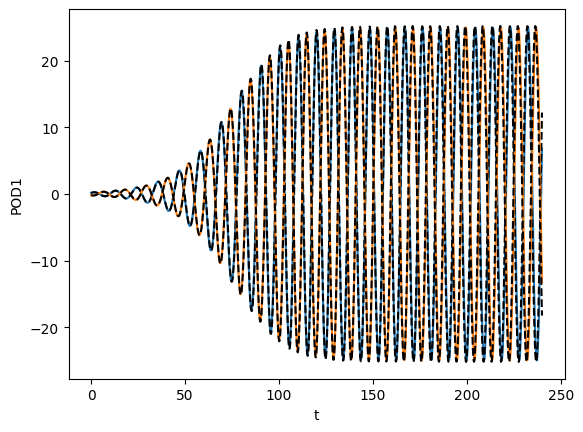

In [4]:
t_predict = ssm.reduced_dynamics_predictions['time']
x_predict = ssm.reduced_dynamics_predictions['reduced_coordinates']
e_predict = ssm.reduced_dynamics_predictions['errors']
for i_traj in (1,4):
    plt.plot(
        t_train[i_traj], 
        x_reduced_train[i_traj][0,:]
    )

    plt.plot(
        t_predict[i_traj], 
        x_predict[i_traj][0,:],
        'k--'
    )

plt.xlabel("t")
plt.ylabel("POD1")

plt.show()  

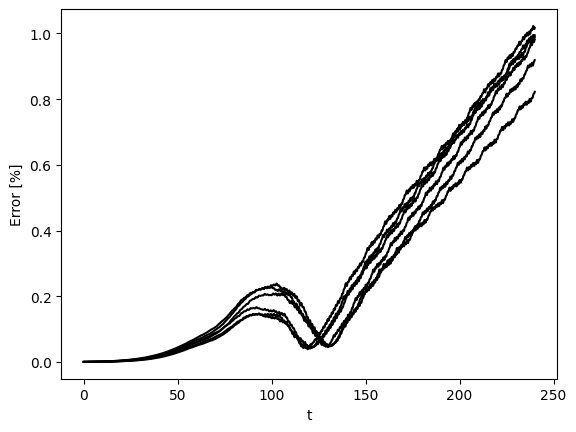

In [5]:
e_predict = ssm.reduced_dynamics_predictions['errors']
for i_traj in range(n_traj_train):
    plt.plot(
        t_predict[i_traj], 
        e_predict[i_traj]*100,
        'k'
    )

plt.xlabel("t")
plt.ylabel("Error [%]")

plt.show()  

In [6]:
print(np.linspace(0, 25, 11))

[ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5 25. ]


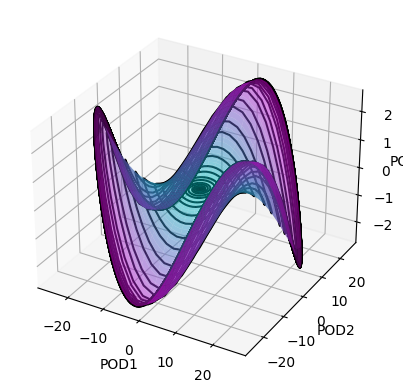

In [26]:
t_predict = ssm.predictions['time']
x_predict = ssm.predictions['observables']
e_predict = ssm.predictions['errors']


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

from matplotlib import cm

# Surface data
r_vec = np.linspace(0, 25, 101)
th_vec = np.linspace(0, 2*np.pi, 101)
r_mesh, th_mesh = np.meshgrid(r_vec,th_vec)
x_mesh, y_mesh = r_mesh*np.cos(th_mesh), r_mesh*np.sin(th_mesh)
x_reduced_surf = np.array([x_mesh.flatten(), y_mesh.flatten(),])

x_full_surf = ssm.decoder.predict(x_reduced_surf.T).T
n_coord = 5
z_vec = x_full_surf[n_coord,:]
z_mesh = z_vec.reshape(x_mesh.shape)
surf_coloring = r_mesh/np.amax(r_mesh)
my_col = cm.cool(np.square(surf_coloring))

surf = ax.plot_surface(x_mesh, y_mesh, z_mesh, facecolors=my_col,
                       linewidth=0, antialiased=True, alpha=0.5)

for i_traj in (1,4):
    ax.plot3D(
        x_reduced_train[i_traj][0,:], 
        x_reduced_train[i_traj][1,:], 
        x_full_train[i_traj][n_coord,:],
        'k'
    )

ax.set_xlabel("POD1")
ax.set_ylabel("POD2")
ax.set_zlabel("POD5")
ax.xaxis.labelpad=1
ax.yaxis.labelpad=1
ax.zaxis.labelpad=1
plt.show()

In [43]:
# import plotly.graph_objects as go

# import pandas as pd

# # Read data from a csv
# z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')



# for i_traj in (1,4):
#     fig = go.Figure(go.Scatter3d(
#         x=x_reduced_train[i_traj][0,:], 
#         y=x_reduced_train[i_traj][1,:], 
#         z=x_full_train[i_traj][n_coord,:],
#         marker=dict(size=0,alpha = 0),
#         line=dict(
#             color='black',
#             width=2
#         )
#     ))

# fig.add_traces(
#     go.Surface(
#     x=x_mesh,
#     y=y_mesh,
#     z=z_mesh,
#     surfacecolor=np.square(surf_coloring)
#     )
#     )

# fig.update_layout(title='Unstable SSM', autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90))

# fig.show()

ValueError: Invalid property specified for object of type plotly.graph_objs.scatter3d.Marker: 'alpha'

Did you mean "line"?

    Valid properties:
        autocolorscale
            Determines whether the colorscale is a default palette
            (`autocolorscale: true`) or the palette determined by
            `marker.colorscale`. Has an effect only if in
            `marker.color` is set to a numerical array. In case
            `colorscale` is unspecified or `autocolorscale` is
            true, the default palette will be chosen according to
            whether numbers in the `color` array are all positive,
            all negative or mixed.
        cauto
            Determines whether or not the color domain is computed
            with respect to the input data (here in `marker.color`)
            or the bounds set in `marker.cmin` and `marker.cmax`
            Has an effect only if in `marker.color` is set to a
            numerical array. Defaults to `false` when `marker.cmin`
            and `marker.cmax` are set by the user.
        cmax
            Sets the upper bound of the color domain. Has an effect
            only if in `marker.color` is set to a numerical array.
            Value should have the same units as in `marker.color`
            and if set, `marker.cmin` must be set as well.
        cmid
            Sets the mid-point of the color domain by scaling
            `marker.cmin` and/or `marker.cmax` to be equidistant to
            this point. Has an effect only if in `marker.color` is
            set to a numerical array. Value should have the same
            units as in `marker.color`. Has no effect when
            `marker.cauto` is `false`.
        cmin
            Sets the lower bound of the color domain. Has an effect
            only if in `marker.color` is set to a numerical array.
            Value should have the same units as in `marker.color`
            and if set, `marker.cmax` must be set as well.
        color
            Sets the marker color. It accepts either a specific
            color or an array of numbers that are mapped to the
            colorscale relative to the max and min values of the
            array or relative to `marker.cmin` and `marker.cmax` if
            set.
        coloraxis
            Sets a reference to a shared color axis. References to
            these shared color axes are "coloraxis", "coloraxis2",
            "coloraxis3", etc. Settings for these shared color axes
            are set in the layout, under `layout.coloraxis`,
            `layout.coloraxis2`, etc. Note that multiple color
            scales can be linked to the same color axis.
        colorbar
            :class:`plotly.graph_objects.scatter3d.marker.ColorBar`
            instance or dict with compatible properties
        colorscale
            Sets the colorscale. Has an effect only if in
            `marker.color` is set to a numerical array. The
            colorscale must be an array containing arrays mapping a
            normalized value to an rgb, rgba, hex, hsl, hsv, or
            named color string. At minimum, a mapping for the
            lowest (0) and highest (1) values are required. For
            example, `[[0, 'rgb(0,0,255)'], [1, 'rgb(255,0,0)']]`.
            To control the bounds of the colorscale in color space,
            use `marker.cmin` and `marker.cmax`. Alternatively,
            `colorscale` may be a palette name string of the
            following list: Blackbody,Bluered,Blues,Cividis,Earth,E
            lectric,Greens,Greys,Hot,Jet,Picnic,Portland,Rainbow,Rd
            Bu,Reds,Viridis,YlGnBu,YlOrRd.
        colorsrc
            Sets the source reference on Chart Studio Cloud for
            `color`.
        line
            :class:`plotly.graph_objects.scatter3d.marker.Line`
            instance or dict with compatible properties
        opacity
            Sets the marker opacity. Note that the marker opacity
            for scatter3d traces must be a scalar value for
            performance reasons. To set a blending opacity value
            (i.e. which is not transparent), set "marker.color" to
            an rgba color and use its alpha channel.
        reversescale
            Reverses the color mapping if true. Has an effect only
            if in `marker.color` is set to a numerical array. If
            true, `marker.cmin` will correspond to the last color
            in the array and `marker.cmax` will correspond to the
            first color.
        showscale
            Determines whether or not a colorbar is displayed for
            this trace. Has an effect only if in `marker.color` is
            set to a numerical array.
        size
            Sets the marker size (in px).
        sizemin
            Has an effect only if `marker.size` is set to a
            numerical array. Sets the minimum size (in px) of the
            rendered marker points.
        sizemode
            Has an effect only if `marker.size` is set to a
            numerical array. Sets the rule for which the data in
            `size` is converted to pixels.
        sizeref
            Has an effect only if `marker.size` is set to a
            numerical array. Sets the scale factor used to
            determine the rendered size of marker points. Use with
            `sizemin` and `sizemode`.
        sizesrc
            Sets the source reference on Chart Studio Cloud for
            `size`.
        symbol
            Sets the marker symbol type.
        symbolsrc
            Sets the source reference on Chart Studio Cloud for
            `symbol`.
        
Did you mean "line"?

Bad property path:
alpha
^^^^^

In [8]:
test_predictions = ssm.predict(t = t_test, x = x_full_test, x_reduced = x_reduced_test)  

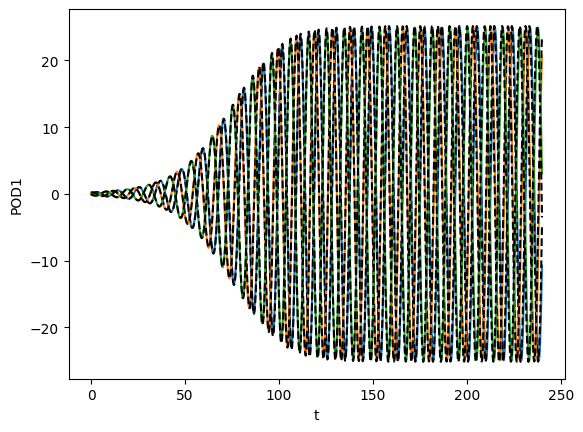

In [9]:
t_predict = test_predictions['time']
x_predict = test_predictions['reduced_coordinates']
e_predict = test_predictions['errors']
for i_traj in range(n_traj_test):
    plt.plot(
        t_test[i_traj], 
        x_reduced_test[i_traj][0,:]
    )

    plt.plot(
        t_predict[i_traj], 
        x_predict[i_traj][0,:],
        'k--'
    )

plt.xlabel("t")
plt.ylabel("POD1")

plt.show()  

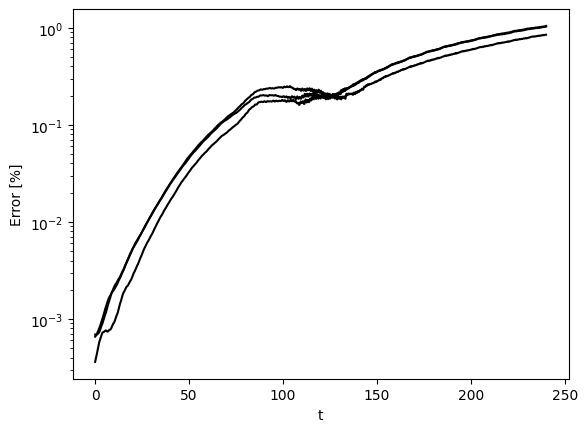

In [10]:
for i_traj in range(n_traj_test):
    plt.plot(
        t_predict[i_traj], 
        e_predict[i_traj]*100,
        'k'
    )

plt.xlabel("t")
plt.ylabel("Error [%]")
plt.yscale("log")
plt.show()  